In [1]:
import os
from pathlib import Path
from collections import defaultdict

import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms
import random

In [2]:
import torch
print(torch.__version__)

2.5.1


In [3]:
torch.set_num_threads(os.cpu_count())
print("Threads set to:", os.cpu_count())

Threads set to: 16


In [4]:
serif_root = r"D:\UIUC\School\FA25\CS 441 AML\FinalProject\font_data\data_serif"

In [5]:
class SerifFontLanguageDataset(Dataset):

    def __init__(self, data_sans_root, transform=None):
        self.root = Path(data_sans_root)
        self.transform = transform

        self.lang2idx = {"JP": 0, "KR": 1, "SC": 2, "TC": 3}
        self.idx2lang = {v: k for k, v in self.lang2idx.items()}

        self.samples = []

        png_paths = sorted(self.root.rglob("*.png"))
        print("Raw PNG count under data_sans:", len(png_paths))

        for p in png_paths:
            try:
                lang_dir = p.parents[1].name
            except:
                continue
            if "_" in lang_dir:
                lang_code = lang_dir.split("_")[-1]
            else:
                lang_code = lang_dir[-2:]
            if lang_code not in self.lang2idx:
                continue

            self.samples.append((p, self.lang2idx[lang_code]))
        print("Filtered PNG count (JP/KR/SC/TC):", len(self.samples))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        img = Image.open(img_path).convert("L")
        if self.transform:
            img = self.transform(img)

        return img, label


In [ ]:
class PathLabelDataset(Dataset):
    def __init__(self, samples, transform=None):
        self.samples = samples
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        p, label = self.samples[idx]
        img = Image.open(p).convert("L")
        if self.transform:
            img = self.transform(img)
        return img, label


def split_by_weight_folders(
    base_dataset,
    train_n=8000, val_n=2000, test_n=2000,
    seed=83
):
    leaf_map = defaultdict(list)

    for img_path, label in base_dataset.samples:
        leaf_map[img_path.parent].append((img_path, label))

    train_samples, val_samples, test_samples = [], [], []

    total_needed = train_n + val_n + test_n
    rng = random.Random(seed)

    for leaf, samples in leaf_map.items():
        rng.shuffle(samples)

        if len(samples) < total_needed:
            continue

        tr = samples[:train_n]
        va = samples[train_n:train_n + val_n]
        te = samples[train_n + val_n:train_n + val_n + test_n]

        train_samples.extend(tr)
        val_samples.extend(va)
        test_samples.extend(te)

    print("Leaf folders found:", len(leaf_map))
    print("Train samples:", len(train_samples))
    print("Val samples:", len(val_samples))
    print("Test samples:", len(test_samples))

    return train_samples, val_samples, test_samples

In [7]:
transform_128 = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

In [8]:
from torch.utils.data import random_split, DataLoader

base_ds = SerifFontLanguageDataset(serif_root, transform=transform_128)

total = len(base_ds)
train_len = int(0.8 * total)
val_len = int(0.1 * total)
test_len = total - train_len - val_len

train_ds, val_ds, test_ds = random_split(
    base_ds, [train_len, val_len, test_len],
    generator=torch.Generator().manual_seed(42)
)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_ds, batch_size=64, shuffle=False, num_workers=0)
test_loader  = DataLoader(test_ds, batch_size=64, shuffle=False, num_workers=0)


Raw PNG count under data_sans: 315876
Filtered PNG count (JP/KR/SC/TC): 315876


In [9]:
x, y = next(iter(train_loader))
print("x shape:", x.shape)
print("y shape:", y.shape)
print("labels example:", y[:10])

x shape: torch.Size([64, 1, 64, 64])
y shape: torch.Size([64])
labels example: tensor([2, 2, 1, 2, 2, 3, 1, 2, 3, 3])


In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [11]:
import torch.nn as nn

class MediumCNNPlus(nn.Module):
    def __init__(self, num_classes=4):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2), 

            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2), 

            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2), 

            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )

        self.pool = nn.AdaptiveAvgPool2d((1, 1))

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(128, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.pool(x)
        return self.classifier(x)

def initializeModel(num_target_classes=4):
    return MediumCNNPlus(num_classes=num_target_classes).to(device)


In [12]:
from matplotlib import pyplot as plt
def plot_results(epochs, train, val, metric_name="Loss"):
    plt.plot(epochs, train, label="train")
    plt.plot(epochs, val, label="val")
    plt.title(metric_name + " Plot")
    plt.ylabel(metric_name)
    plt.xlabel("Epoch")
    plt.legend()
    plt.show()

def save_checkpoint(save_dir, model, save_name = 'best_model.pth'):
    save_path = os.path.join(save_dir, save_name)
    torch.save(model.state_dict(), save_path)

def load_model(model, save_dir, save_name = 'best_model.pth'):
    save_path = os.path.join(save_dir, save_name)
    model.load_state_dict(torch.load(save_path))
    return model

In [13]:
import torch
import numpy as np
from tqdm import tqdm

def train(train_loader, model, criterion, optimizer):
    model.train()
    losses = []

    it_train = tqdm(enumerate(train_loader), total=len(train_loader), desc="Training ...", position=0)
    for i, (images, labels) in it_train:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        losses.append(loss.detach())
        it_train.set_description(f'loss: {loss.item():.3f}')

    return torch.stack(losses).mean().item()


def test(test_loader, model, criterion):
    model.eval()
    losses = []
    correct = 0
    total = 0

    it_test = tqdm(enumerate(test_loader), total=len(test_loader), desc="Validating ...", position=0)
    with torch.no_grad():
        for i, (images, labels) in it_test:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            losses.append(loss.detach())

            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    mean_accuracy = correct / total if total > 0 else 0.0
    test_loss = torch.stack(losses).mean().item() if len(losses) > 0 else 0.0

    print(f'correct: {correct}, total: {total}')
    print(f'Mean Accuracy: {mean_accuracy:.4f}')
    print(f'Avg loss: {test_loss:.4f}')

    return mean_accuracy, test_loss


In [14]:
import sys
print(sys.executable)

c:\Users\sam\anaconda3\envs\pyCS441Final\python.exe


In [15]:
device = torch.device("cpu")  

Training:   0%|          | 0/15 [00:00<?, ?it/s]

loss: 0.914: 100%|██████████| 3949/3949 [29:28<00:00,  2.23it/s]


Train loss epoch 0: 0.9983053207397461


Validating ...: 100%|██████████| 3949/3949 [03:48<00:00, 17.26it/s]


correct: 126982, total: 252700
Mean Accuracy: 0.5025
Avg loss: 1.0793


Training:   7%|▋         | 1/15 [35:56<8:23:06, 2156.17s/it]

correct: 15857, total: 31587
Mean Accuracy: 0.5020
Avg loss: 1.0863
Train acc: 0.5025009893153938 | Val acc: 0.5020103207015545
Saved best model


loss: 0.871: 100%|██████████| 3949/3949 [08:12<00:00,  8.02it/s]


Train loss epoch 1: 0.8636559247970581


Validating ...: 100%|██████████| 3949/3949 [04:24<00:00, 14.92it/s]


correct: 136697, total: 252700
Mean Accuracy: 0.5409
Avg loss: 1.4610


Training:  13%|█▎        | 2/15 [49:06<4:53:08, 1352.99s/it]

correct: 17086, total: 31587
Mean Accuracy: 0.5409
Avg loss: 1.4776
Train acc: 0.5409457855164226 | Val acc: 0.5409187323899073
Saved best model


loss: 0.900: 100%|██████████| 3949/3949 [09:08<00:00,  7.20it/s]


Train loss epoch 2: 0.8034682273864746


Validating ...: 100%|██████████| 3949/3949 [04:24<00:00, 14.94it/s]


correct: 158384, total: 252700
Mean Accuracy: 0.6268
Avg loss: 0.7773


Training:  20%|██        | 3/15 [1:03:13<3:44:20, 1121.71s/it]

correct: 19553, total: 31587
Mean Accuracy: 0.6190
Avg loss: 0.7949
Train acc: 0.6267669172932331 | Val acc: 0.6190204831101402
Saved best model


loss: 0.853: 100%|██████████| 3949/3949 [09:11<00:00,  7.16it/s]


Train loss epoch 3: 0.7480977773666382


Validating ...: 100%|██████████| 3949/3949 [04:26<00:00, 14.85it/s]


correct: 163426, total: 252700
Mean Accuracy: 0.6467
Avg loss: 0.7257


Training:  27%|██▋       | 4/15 [1:17:24<3:06:01, 1014.70s/it]

correct: 19957, total: 31587
Mean Accuracy: 0.6318
Avg loss: 0.7651
Train acc: 0.6467194301543332 | Val acc: 0.631810554975148
Saved best model


loss: 0.797: 100%|██████████| 3949/3949 [09:13<00:00,  7.14it/s]


Train loss epoch 4: 0.7282509803771973


Validating ...: 100%|██████████| 3949/3949 [04:27<00:00, 14.77it/s]


correct: 151175, total: 252700
Mean Accuracy: 0.5982
Avg loss: 0.9298


Training:  33%|███▎      | 5/15 [1:31:39<2:39:31, 957.11s/it] 

correct: 18478, total: 31587
Mean Accuracy: 0.5850
Avg loss: 0.9907
Train acc: 0.5982390185991294 | Val acc: 0.5849874948554785


loss: 0.763: 100%|██████████| 3949/3949 [09:14<00:00,  7.12it/s]


Train loss epoch 5: 0.7123231887817383


Validating ...: 100%|██████████| 3949/3949 [04:21<00:00, 15.08it/s]


correct: 160381, total: 252700
Mean Accuracy: 0.6347
Avg loss: 0.7862


Training:  40%|████      | 6/15 [1:45:49<2:18:09, 921.00s/it]

correct: 19377, total: 31587
Mean Accuracy: 0.6134
Avg loss: 0.8682
Train acc: 0.6346695686584883 | Val acc: 0.6134485706144933


loss: 0.655: 100%|██████████| 3949/3949 [09:12<00:00,  7.14it/s]


Train loss epoch 6: 0.6838676333427429


Validating ...: 100%|██████████| 3949/3949 [04:22<00:00, 15.06it/s]


correct: 166710, total: 252700
Mean Accuracy: 0.6597
Avg loss: 0.6811


Training:  47%|████▋     | 7/15 [2:00:00<1:59:42, 897.80s/it]

correct: 20078, total: 31587
Mean Accuracy: 0.6356
Avg loss: 0.7416
Train acc: 0.6597150771666007 | Val acc: 0.6356412448159052
Saved best model


loss: 0.618: 100%|██████████| 3949/3949 [09:08<00:00,  7.19it/s]


Train loss epoch 7: 0.6736587285995483


Validating ...: 100%|██████████| 3949/3949 [04:28<00:00, 14.73it/s]


correct: 169993, total: 252700
Mean Accuracy: 0.6727
Avg loss: 0.6587


Training:  53%|█████▎    | 8/15 [2:14:09<1:42:56, 882.37s/it]

correct: 20566, total: 31587
Mean Accuracy: 0.6511
Avg loss: 0.7422
Train acc: 0.6727067669172933 | Val acc: 0.6510906385538354
Saved best model


loss: 0.782: 100%|██████████| 3949/3949 [09:07<00:00,  7.21it/s]


Train loss epoch 8: 0.665032684803009


Validating ...: 100%|██████████| 3949/3949 [04:24<00:00, 14.95it/s]


correct: 166450, total: 252700
Mean Accuracy: 0.6587
Avg loss: 0.7031


Training:  60%|██████    | 9/15 [2:28:14<1:27:03, 870.60s/it]

correct: 19979, total: 31587
Mean Accuracy: 0.6325
Avg loss: 0.7942
Train acc: 0.6586861891571033 | Val acc: 0.6325070440371039


loss: 0.683: 100%|██████████| 3949/3949 [09:11<00:00,  7.17it/s]


Train loss epoch 9: 0.648084282875061


Validating ...: 100%|██████████| 3949/3949 [04:22<00:00, 15.07it/s]


correct: 171380, total: 252700
Mean Accuracy: 0.6782
Avg loss: 0.6255


Training:  67%|██████▋   | 10/15 [2:42:19<1:11:54, 862.86s/it]

correct: 20589, total: 31587
Mean Accuracy: 0.6518
Avg loss: 0.7174
Train acc: 0.6781954887218045 | Val acc: 0.6518187862095166
Saved best model


loss: 0.608: 100%|██████████| 3949/3949 [09:08<00:00,  7.20it/s]


Train loss epoch 10: 0.6421577334403992


Validating ...: 100%|██████████| 3949/3949 [04:21<00:00, 15.12it/s]


correct: 171783, total: 252700
Mean Accuracy: 0.6798
Avg loss: 0.6231


Training:  73%|███████▎  | 11/15 [2:56:23<57:07, 856.96s/it]  

correct: 20421, total: 31587
Mean Accuracy: 0.6465
Avg loss: 0.7299
Train acc: 0.6797902651365255 | Val acc: 0.6465001424636717


loss: 0.749: 100%|██████████| 3949/3949 [09:09<00:00,  7.19it/s]


Train loss epoch 11: 0.6375965476036072


Validating ...: 100%|██████████| 3949/3949 [04:23<00:00, 14.99it/s]


correct: 171187, total: 252700
Mean Accuracy: 0.6774
Avg loss: 0.6341


Training:  80%|████████  | 12/15 [3:10:28<42:40, 853.44s/it]

correct: 20279, total: 31587
Mean Accuracy: 0.6420
Avg loss: 0.7313
Train acc: 0.6774317372378315 | Val acc: 0.6420046221546839


loss: 0.678: 100%|██████████| 3949/3949 [09:11<00:00,  7.16it/s]


Train loss epoch 12: 0.6273983120918274


Validating ...: 100%|██████████| 3949/3949 [04:23<00:00, 14.97it/s]


correct: 172856, total: 252700
Mean Accuracy: 0.6840
Avg loss: 0.6068


Training:  87%|████████▋ | 13/15 [3:24:35<28:23, 851.62s/it]

correct: 20607, total: 31587
Mean Accuracy: 0.6524
Avg loss: 0.7257
Train acc: 0.6840364068064899 | Val acc: 0.6523886408965713
Saved best model


loss: 0.723: 100%|██████████| 3949/3949 [09:11<00:00,  7.16it/s]


Train loss epoch 13: 0.6241437792778015


Validating ...: 100%|██████████| 3949/3949 [04:25<00:00, 14.86it/s]


correct: 172914, total: 252700
Mean Accuracy: 0.6843
Avg loss: 0.6079


Training:  93%|█████████▎| 14/15 [3:38:45<14:11, 851.10s/it]

correct: 20560, total: 31587
Mean Accuracy: 0.6509
Avg loss: 0.7197
Train acc: 0.6842659279778394 | Val acc: 0.6509006869914838


loss: 0.715: 100%|██████████| 3949/3949 [09:08<00:00,  7.20it/s]


Train loss epoch 14: 0.6218391060829163


Validating ...: 100%|██████████| 3949/3949 [04:21<00:00, 15.11it/s]


correct: 173297, total: 252700
Mean Accuracy: 0.6858
Avg loss: 0.6027


Training: 100%|██████████| 15/15 [3:52:48<00:00, 931.23s/it]


correct: 20480, total: 31587
Mean Accuracy: 0.6484
Avg loss: 0.7169
Train acc: 0.6857815591610605 | Val acc: 0.6483679994934625


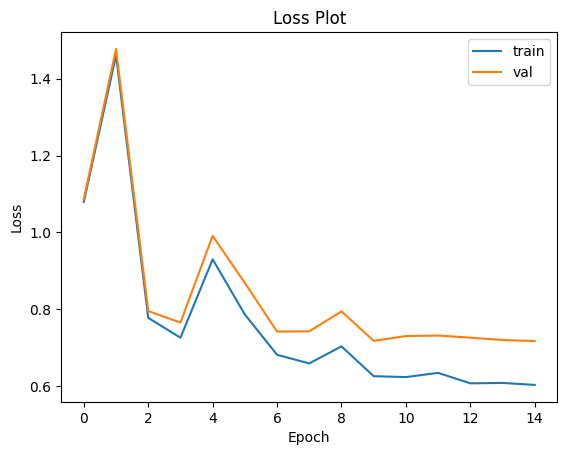

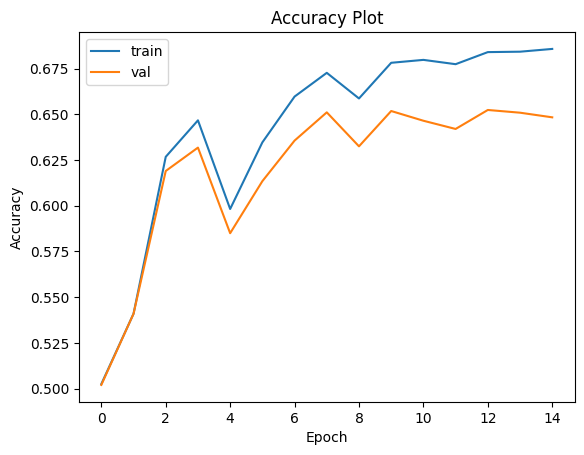

C:\Users\sam\AppData\Local\Temp\ipykernel_88428\97822465.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(save_path))
Validating ...: 10

correct: 20499, total: 31589
Mean Accuracy: 0.6489
Avg loss: 0.7265
Final Test acc: 0.6489284244515496
Final Test loss: 0.726520836353302


In [ ]:
import os
from tqdm import tqdm

save_dir = "./checkpoints_lang_sans"
os.makedirs(save_dir, exist_ok=True)

model = initializeModel(num_target_classes=4)

num_epochs = 15
test_interval = 1

learn_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)

criterion = torch.nn.CrossEntropyLoss()

epochs_list = []
train_losses = []
train_accuracy_list = []
val_losses = []
val_accuracy_list = []

for epoch in tqdm(range(num_epochs), total=num_epochs, desc="Training"):

    train_loss = train(train_loader, model, criterion, optimizer)
    lr_scheduler.step()

    print(f"Train loss epoch {epoch}: {train_loss}")

    if (epoch % test_interval == 0) or (epoch == num_epochs - 1):
        epochs_list.append(epoch)

        train_acc, train_loss_eval = test(train_loader, model, criterion)
        train_losses.append(train_loss_eval)
        train_accuracy_list.append(train_acc)

        val_acc, val_loss = test(val_loader, model, criterion)
        val_losses.append(val_loss)
        val_accuracy_list.append(val_acc)

        print(f"Train acc: {train_acc} | Val acc: {val_acc}")

        if len(val_accuracy_list) == 1 or val_acc >= max(val_accuracy_list[:-1]):
            save_checkpoint(save_dir, model, save_name="best_model.pth")
            print("Saved best model")

plot_results(epochs_list, train_losses, val_losses, "Loss")
plot_results(epochs_list, train_accuracy_list, val_accuracy_list, "Accuracy")

model = initializeModel(num_target_classes=4)
load_model(model, save_dir, save_name="best_model.pth")

test_acc, test_loss = test(test_loader, model, criterion)
print("Final Test acc:", test_acc)
print("Final Test loss:", test_loss)


In [17]:
def get_preds_labels(model, loader, device):
    model.eval()
    preds_all, labels_all = [], []

    for images, labels in loader:
        images = images.to(device)
        outputs = model(images)
        preds = outputs.argmax(dim=1).cpu().numpy()

        preds_all.append(preds)
        labels_all.append(labels.numpy())

    return np.concatenate(preds_all), np.concatenate(labels_all)


In [18]:
from sklearn.metrics import classification_report, confusion_matrix


model = model.to(device)


preds, labels = get_preds_labels(model, test_loader, device)

print("\nClassification report:")
print(classification_report(
    labels, preds,
    target_names=["JP", "KR", "SC", "TC"],
    digits=4
))

print("Confusion matrix:")
print(confusion_matrix(labels, preds))



Classification report:
              precision    recall  f1-score   support

          JP     0.4589    0.6708    0.5449      5464
          KR     0.9842    0.5577    0.7120      8146
          SC     0.6108    0.8574    0.7134     11243
          TC     0.8277    0.3936    0.5335      6736

    accuracy                         0.6489     31589
   macro avg     0.7204    0.6199    0.6259     31589
weighted avg     0.7270    0.6489    0.6455     31589

Confusion matrix:
[[3665   49 1686   64]
 [2422 4543 1129   52]
 [1151   16 9640  436]
 [ 749    8 3328 2651]]
